In [1]:
#Useful Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chart_studio.plotly
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.offline import iplot

pyo.init_notebook_mode()
pd.set_option('display.max_columns', 500)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# Preprocessing

### Sample examples

In [50]:
#Loading the raw data
raw_data=pd.read_csv('data/results.csv')
raw_data.sample(5)

date      home_team     away_team  home_score  away_score  \
11504  1980-11-11         Greece     Australia           3           3   
35821  2014-02-01  United States   South Korea           2           0   
266    1910-06-12      Argentina       Uruguay           4           1   
35806  2014-01-21        Iceland        Sweden           0           2   
20834  1997-09-19           Iran  Saudi Arabia           1           1   

                         tournament          city               country  \
11504                      Friendly        Athens                Greece   
35821                      Friendly        Carson         United States   
266                        Friendly  Buenos Aires             Argentina   
35806                      Friendly     Abu Dhabi  United Arab Emirates   
20834  FIFA World Cup qualification       Teheran                  Iran   

       neutral  
11504    False  
35821    False  
266      False  
35806     True  
20834    False

The dataset at hand is pretty straight-forward, and it seems to have no missing data nor corrupted information. That being said, some irrelevant information can be observed:

In [3]:
raw_data[raw_data['home_team']=='Provence'].head()

date home_team        away_team  home_score  away_score  \
30447  2008-07-08  Provence          Padania           1           6   
30448  2008-07-09  Provence  Iraqi Kurdistan           0           3   
31359  2009-06-22  Provence             Gozo           3           1   
31368  2009-06-25  Provence  Iraqi Kurdistan           0           6   
31371  2009-06-26  Provence            Sápmi           4           4   

           tournament        city country  neutral  
30447  Viva World Cup   Gällivare  Sweden     True  
30448  Viva World Cup  Malmberget  Sweden     True  
31359  Viva World Cup      Novara   Italy     True  
31368  Viva World Cup      Varese   Italy     True  
31371  Viva World Cup     Brescia   Italy     True

Teams representing cities or regions can be observed, so the international matches featured in the dataset do not strickly include national teams, but rather any team that participated to an international match at some point. We need to get rid of them, since they are not affiliated with FIFA.

In [4]:
#Removing all teams not recognised by the FIFA (non-national and unofficial teams)
official_teams=raw_data[raw_data['tournament']=='FIFA World Cup qualification']
official_teams=pd.concat([official_teams['home_team'],official_teams['away_team']]).unique()
team_filter=raw_data['home_team'].isin(official_teams) & raw_data['away_team'].isin(official_teams)
removed_teams=pd.concat([raw_data[~raw_data['home_team'].isin(official_teams)]['home_team'],raw_data[~raw_data['away_team'].isin(official_teams)]['away_team']]).unique()
data=raw_data[team_filter]
#Printing the name of all removed teams
print('Removed teams:',removed_teams)

Removed teams: ['Catalonia' 'Basque Country' 'Brittany' 'Galicia' 'Andalusia'
 'Central Spain' 'Silesia' 'Guadeloupe' 'French Guiana' 'Manchukuo'
 'Martinique' 'Réunion' 'Zanzibar' 'Kernow' 'North Vietnam'
 'Northern Cyprus' 'Kiribati' 'Wallis Islands and Futuna' 'Greenland'
 'Niue' 'Palau' 'Sint Maarten' 'Åland Islands' 'Ynys Môn' 'Saint Martin'
 'Jersey' 'Shetland' 'Isle of Wight' 'Guernsey' 'Isle of Man'
 'Canary Islands' 'Frøya' 'Hitra' 'Corsica' 'Gotland' 'Saare County'
 'Rhodes' 'Micronesia' 'Orkney' 'Monaco' 'Tuvalu' 'Sark' 'Alderney'
 'Mayotte' 'Western Isles' 'Falkland Islands' 'Republic of St. Pauli'
 'Găgăuzia' 'Tibet' 'Crimea' 'Occitania' 'Sápmi'
 'Northern Mariana Islands' 'Menorca' 'Provence' 'Arameans Suryoye'
 'Padania' 'Iraqi Kurdistan' 'Gozo' 'Bonaire' 'Western Sahara' 'Raetia'
 'Darfur' 'Tamil Eelam' 'Abkhazia' 'Saint Pierre and Miquelon' 'Artsakh'
 'Madrid' 'Vatican City' 'Ellan Vannin' 'South Ossetia' 'County of Nice'
 'Székely Land' 'Romani people' 'Felvidék' 'Cha

# Exploratory Analysis

### Data types for a given sample

In [5]:
data.shape

(39654, 9)

In [6]:
pd.DataFrame(data.dtypes).T

date home_team away_team home_score away_score tournament    city  \
0  object    object    object      int64      int64     object  object   

  country neutral  
0  object    bool

____
## Number of matches played
### Distribution of the number of matches played by decade

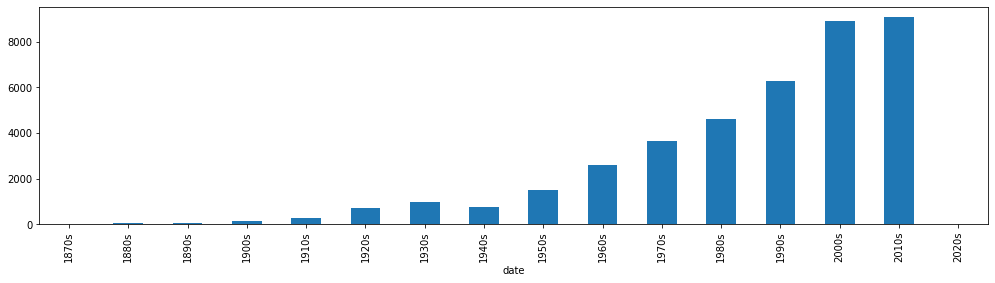

In [7]:
decades=data['date'].str.slice(0,3)
decades=decades.astype(str)+'0s'
decades=decades.groupby(decades).count()
pd.DataFrame(decades).plot.bar(y=0,legend=False, figsize=(17,4))
plt.show()  

We notice that the amount of international matches played per year increases exponentially over time.

### Distribution of the total number of matches played per team (full distribution, top and bottom 50)

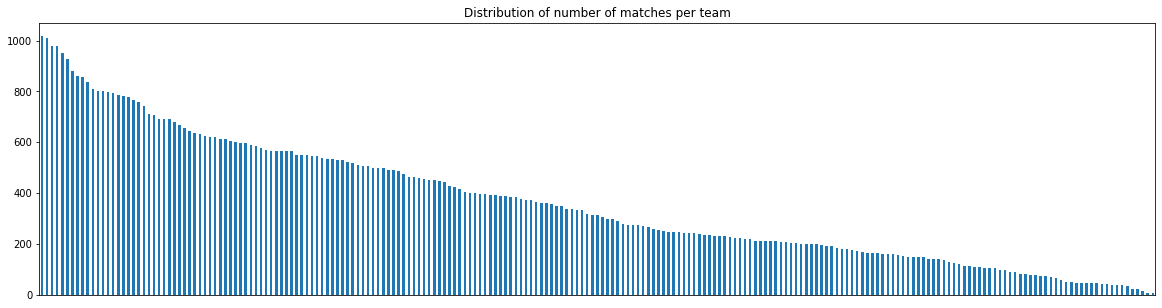

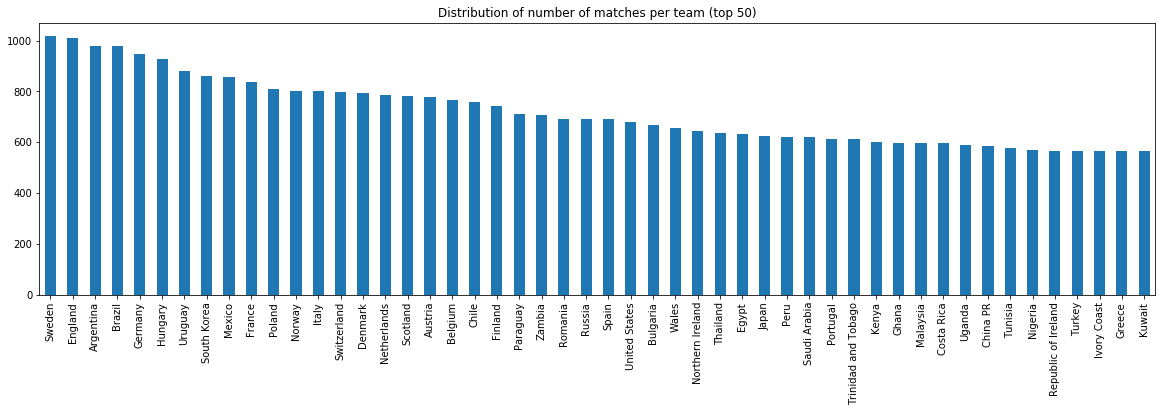

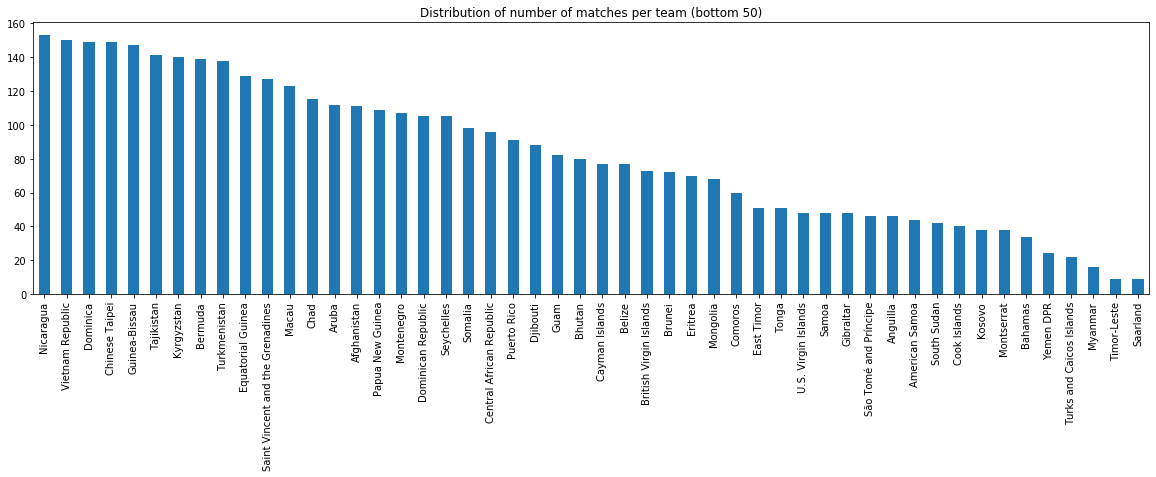

In [8]:
match_participants=pd.concat([data['home_team'],data['away_team']])
match_participants=match_participants.groupby(match_participants).count().sort_values(0, ascending=False)
pd.DataFrame(match_participants[:]).plot.bar(y=0,legend=False, figsize=(20,5),
                                                title='Distribution of number of matches per team')
f = plt.gca()
f.axes.get_xaxis().set_visible(False)
pd.DataFrame(match_participants[:50]).plot.bar(y=0,legend=False, figsize=(20,5),
                                               title='Distribution of number of matches per team (top 50)')
pd.DataFrame(match_participants[-50:]).plot.bar(y=0,legend=False, figsize=(20,5),
                                                title='Distribution of number of matches per team (bottom 50)')

plt.show()

In [9]:
pd.DataFrame(match_participants.describe()).T

count        mean         std  min    25%    50%    75%     max
0  219.0  362.136986  245.589012  9.0  163.5  312.0  542.0  1018.0

We can observe a sharp difference in the number of matches played between the top 50 and bottom 50 teams. This explains the large standard deviation. In addition, we notice that the teams playing the least are often teams from small countries.


### Distribution of the total number of home matches played per team (top and bottom 50)

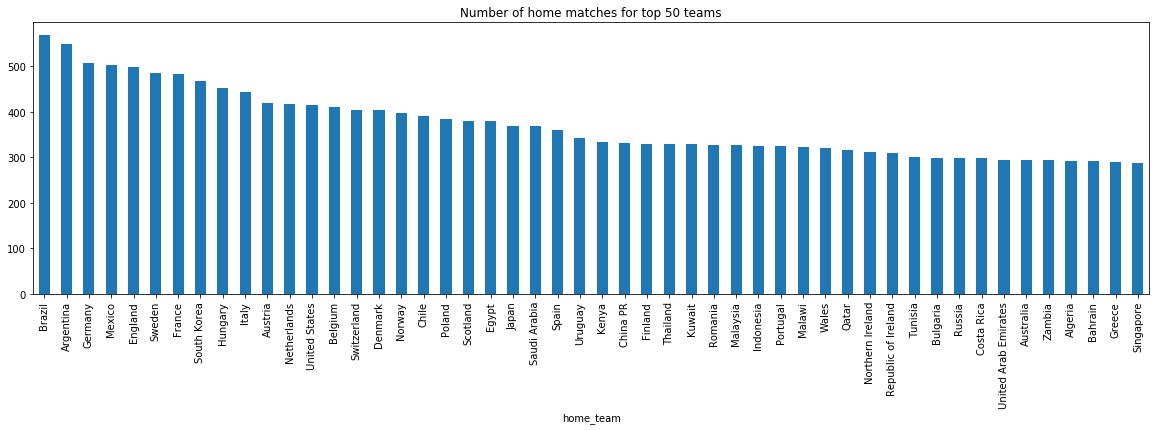

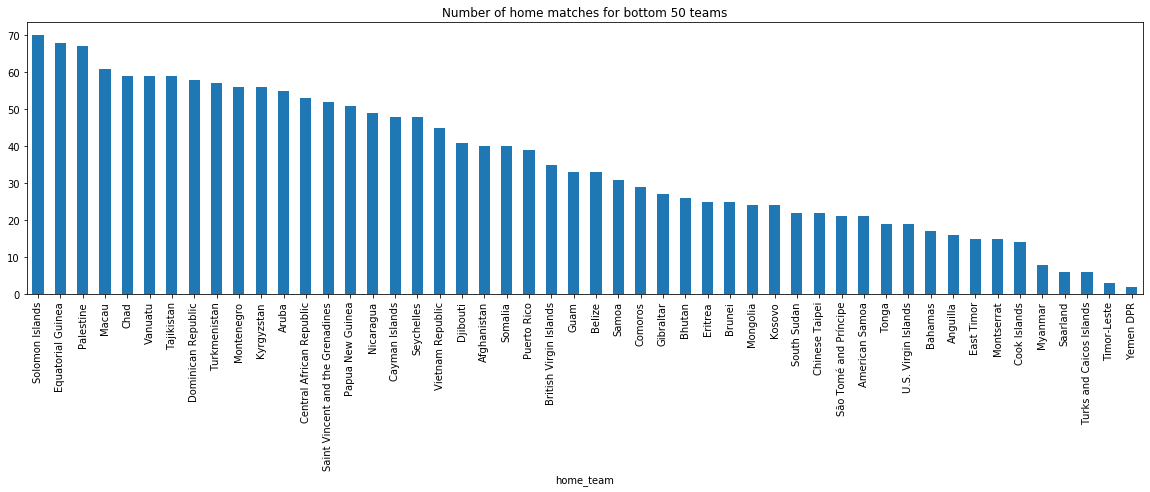

In [10]:
home_participants=data['home_team'].groupby(data['home_team']).count().sort_values(0, ascending=False)
pd.DataFrame(home_participants[:50]).plot.bar(y=0,legend=False, figsize=(20,5),
                                              title='Number of home matches for top 50 teams')

pd.DataFrame(home_participants[-50:]).plot.bar(y=0,legend=False, figsize=(20,5),
                                              title='Number of home matches for bottom 50 teams')
plt.show()

### Distribution ofthe total number of away matches played per team (top and bottom 50)


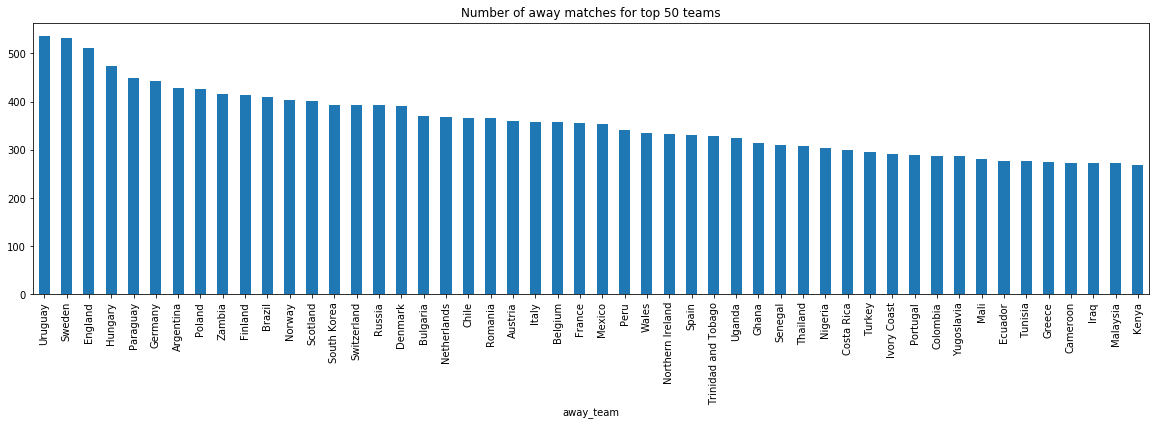

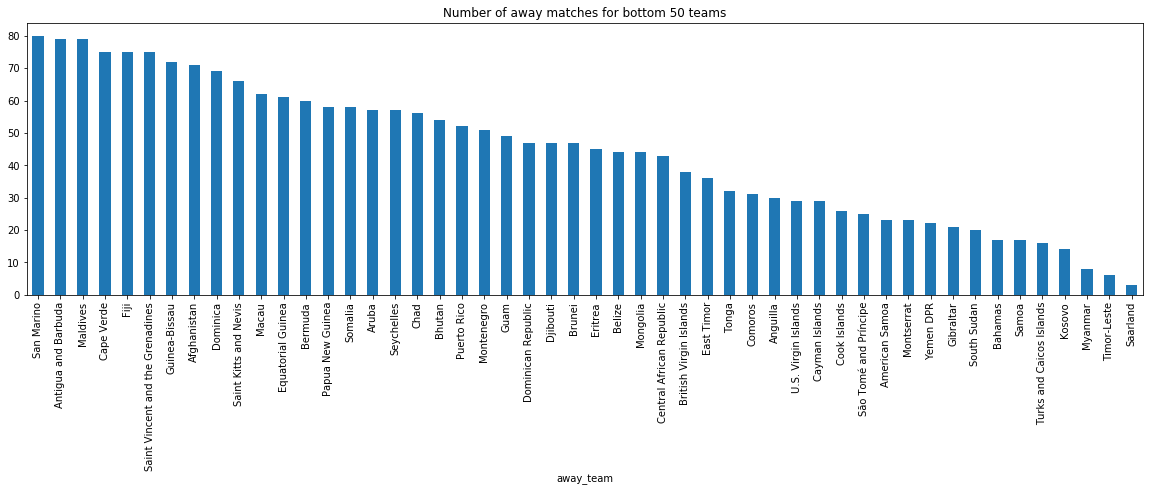

In [11]:
away_participants=data['away_team'].groupby(data['away_team']).count().sort_values(0, ascending=False)
pd.DataFrame(away_participants[:50]).plot.bar(y=0,legend=False, figsize=(20,5),
                                              title='Number of away matches for top 50 teams')
pd.DataFrame(away_participants[-50:]).plot.bar(y=0,legend=False, figsize=(20,5),
                                               title='Number of away matches for bottom 50 teams')
plt.show()

## Scores
### Distribution of goals scored by individual teams per match

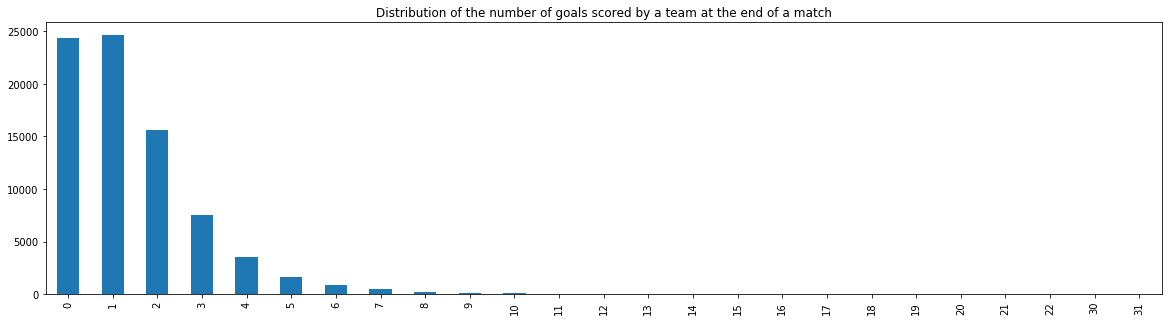

In [12]:
final_scores=pd.concat([data['home_score'],data['away_score']])
final_score_count=final_scores.groupby(final_scores).count()
pd.DataFrame(final_score_count).plot.bar(y=0,legend=False, figsize=(20,5),
                                              title='Distribution of the number of goals scored by a team at the end of a match')
plt.show()

In [13]:
pd.DataFrame(final_scores.describe()).T

count      mean       std  min  25%  50%  75%   max
0  79308.0  1.445226  1.567368  0.0  0.0  1.0  2.0  31.0

### Distribution of goals scored by home teams per match

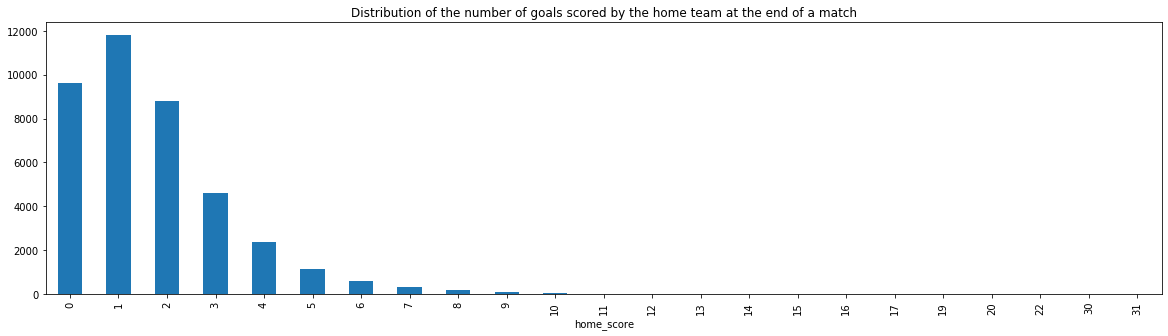

In [14]:
home_final_score_count=data['home_score'].groupby(data['home_score']).count()
pd.DataFrame(home_final_score_count).plot.bar(y=0,legend=False, figsize=(20,5),
                                              title='Distribution of the number of goals scored by the home team at the end of a match')
plt.show()

It seem to follow an Erlang distribution.

### Distribution of goals scored by away teams per match

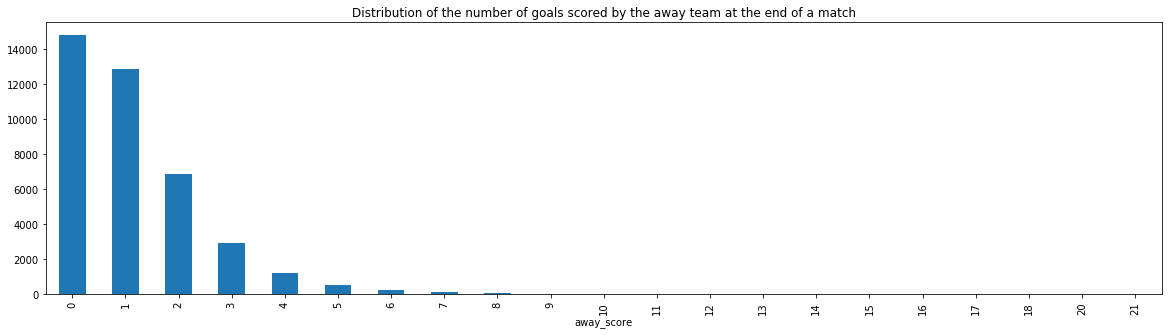

In [15]:
away_final_score_count=data['away_score'].groupby(data['away_score']).count()
pd.DataFrame(away_final_score_count).plot.bar(y=0,legend=False, figsize=(20,5),
                                              title='Distribution of the number of goals scored by the away team at the end of a match')
plt.show()

Here, the likelihood of each outcome seems to decrease exponentially with the number of goals scored. 

### Distribution of goals scored by both teams per match 

Let's now look at the total number of goals per game (home + away goals):

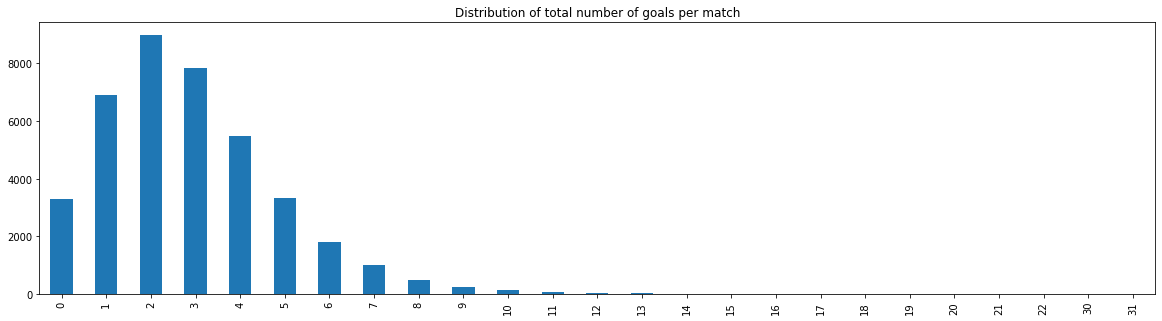

In [16]:
total_scores = data['home_score'] + data['away_score']
total_scores_count=total_scores.groupby(total_scores).count()
pd.DataFrame(total_scores_count).plot.bar(y=0,legend=False, figsize=(20,5),
                                              title='Distribution of total number of goals per match')
plt.show()

The total number of goals scored per match seems to follow an Erlang distribution. To get this corresponding random variable, we have summed-up a variable which seemingly follows an exponential distribution with one which seems to follow an Erlang distribution. This might mean that the two variables are independent. This would imply that only the strength and skills of a team has an influence of its performance and the number of goals it scores, not the number of goals scored by the opponent.

In [17]:
pd.DataFrame(total_scores.describe()).T

count      mean       std  min  25%  50%  75%   max
0  39654.0  2.890452  2.036908  0.0  1.0  3.0  4.0  31.0

## Types of matches

### Repartition of friendly vs non-friendly (competitive) matches

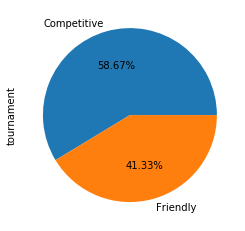

In [18]:
f_vs_c=data['tournament'].copy()
f_vs_c[f_vs_c!='Friendly']='Competitive'
pd.DataFrame(f_vs_c).groupby(f_vs_c).count().plot.pie(y=0, autopct='%1.2f%%', startangle=0, legend=False)
plt.show()

We can see that a surpringly large amount of matches played are friendly.

## Distribution of matches per tournament

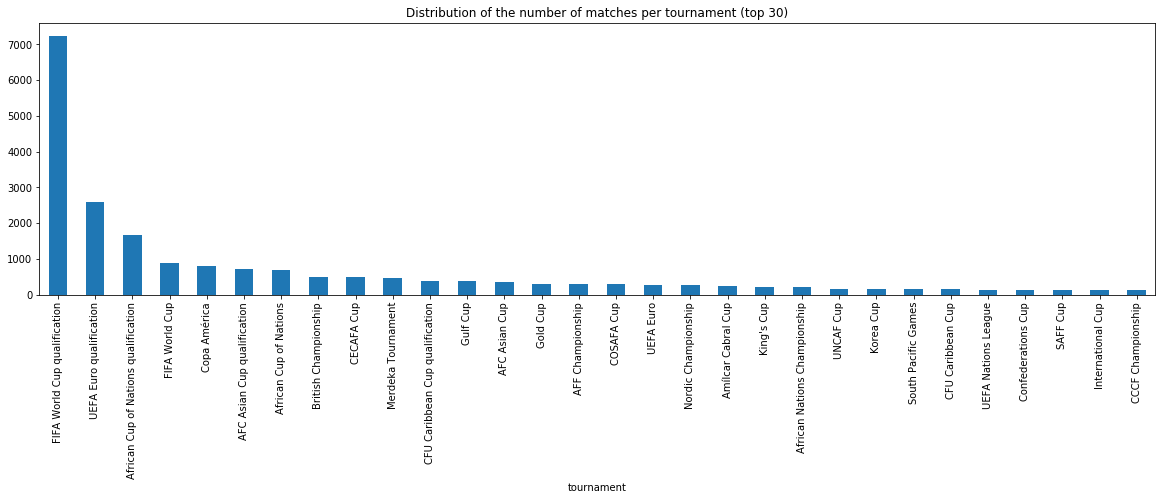

In [19]:
tournament_count=data['tournament'].groupby(data['tournament']).count().sort_values(0, ascending=False).drop('Friendly')
pd.DataFrame(tournament_count[:30]).plot.bar(y=0,legend=False, figsize=(20,5),
                                              title='Distribution of the number of matches per tournament (top 30)')
plt.show()

A huge majority of competitive international matches are FIFA World Cup qualifications matches.

Here is a list of all the international competitions existing in the dataset:

In [20]:
tournament_list = sorted(data['tournament'].unique())
a = [print('•', i, end=' ') for i in tournament_list]
print('\n\nNumber of competitions:', len(tournament_list))

• ABCS Tournament • AFC Asian Cup • AFC Asian Cup qualification • AFC Challenge Cup • AFC Challenge Cup qualification • AFF Championship • AFF Championship qualification • African Cup of Nations • African Cup of Nations qualification • African Nations Championship • African Nations Championship qualification • Amílcar Cabral Cup • Atlantic Cup • Balkan Cup • Baltic Cup • Brazil Independence Cup • British Championship • CCCF Championship • CECAFA Cup • CFU Caribbean Cup • CFU Caribbean Cup qualification • CONCACAF Championship • CONCACAF Championship qualification • CONCACAF Nations League • CONCACAF Nations League qualification • COSAFA Cup • Confederations Cup • Copa América • Copa América qualification • Copa Artigas • Copa Bernardo O'Higgins • Copa Carlos Dittborn • Copa Chevallier Boutell • Copa Félix Bogado • Copa Juan Pinto Durán • Copa Lipton • Copa Newton • Copa Oswaldo Cruz • Copa Paz del Chaco • Copa Premio Honor Argentino • Copa Premio Honor Uruguayo • Copa Ramón Castilla • 

Let's take a closer look at the biggest competition: the FIFA World Cup.

### FIFA World Cup statistics

In [21]:
WC_data = data[data.tournament == 'FIFA World Cup']
WC_data.tail(16)

date home_team    away_team  home_score  away_score  \
39933  2018-06-30    France    Argentina           4           3   
39934  2018-06-30   Uruguay     Portugal           2           1   
39935  2018-07-01    Russia        Spain           1           1   
39936  2018-07-01   Croatia      Denmark           1           1   
39937  2018-07-02    Brazil       Mexico           2           0   
39938  2018-07-02   Belgium        Japan           3           2   
39939  2018-07-03    Sweden  Switzerland           1           0   
39940  2018-07-03  Colombia      England           1           1   
39942  2018-07-06   Uruguay       France           0           2   
39943  2018-07-06    Brazil      Belgium           1           2   
39944  2018-07-07    Sweden      England           0           2   
39945  2018-07-07    Russia      Croatia           2           2   
39946  2018-07-10    France      Belgium           1           0   
39947  2018-07-11   Croatia      England           2           1   
39948  2018-07-14   Belgium      England           2           0   
39949  2018-07-15    France      Croatia           4           2   

           tournament             city country  neutral  
39933  FIFA World Cup            Kazan  Russia     True  
39934  FIFA World Cup            Sochi  Russia     True  
39935  FIFA World Cup           Moscow  Russia    False  
39936  FIFA World Cup  Nizhny Novgorod  Russia     True  
39937  FIFA World Cup           Samara  Russia     True  
39938  FIFA World Cup    Rostov-on-Don  Russia     True  
39939  FIFA World Cup   St. Petersburg  Russia     True  
39940  FIFA World Cup           Moscow  Russia     True  
39942  FIFA World Cup  Nizhny Novgorod  Russia     True  
39943  FIFA World Cup            Kazan  Russia     True  
39944  FIFA World Cup           Samara  Russia     True  
39945  FIFA World Cup            Sochi  Russia    False  
39946  FIFA World Cup   St. Petersburg  Russia     True  
39947  FIFA World Cup           Moscow  Russia     True  
39948  FIFA World Cup   St. Petersburg  Russia     True  
39949  FIFA World Cup           Moscow  Russia     True

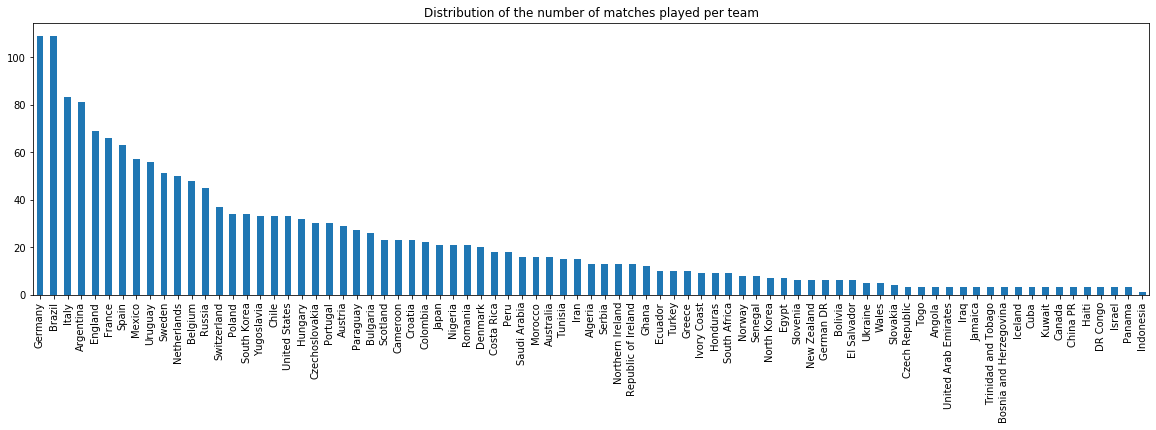

In [22]:
WC_match_participants=pd.concat([WC_data['home_team'],WC_data['away_team']])
WC_match_participants_count=WC_match_participants.groupby(WC_match_participants).count().sort_values(0, ascending=False)
pd.DataFrame(WC_match_participants_count).plot.bar(y=0,legend=False, figsize=(20,5),
                                                title='Distribution of the number of matches played per team')
plt.show()

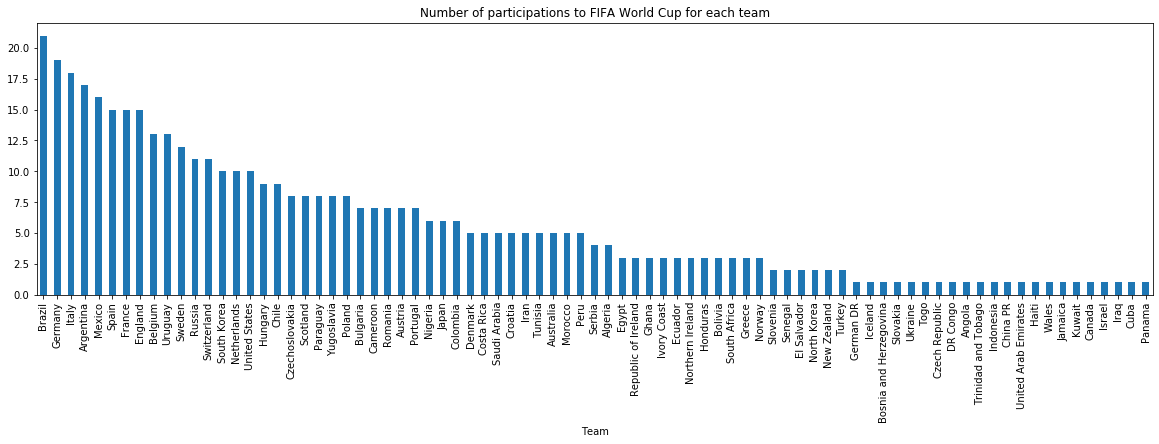

In [23]:
def append(dic, team):
    if team not in dic:
        dic[team] = []
        dic[team].append(1)
        dic[team].append(row.date[:4])
    if row.date[:4] not in dic[team]:
        dic[team][0] += 1
        dic[team].append(row.date[:4])
    return dic

dic = {}
date = []
for i in range(len(WC_data)):
    row = WC_data.iloc[i]
    team = row.home_team
    dic = append(dic, team)
    team = row.away_team
    dic = append(dic, team)
for e in dic:
    dic[e] = dic[e][0]
    
WC_participation = pd.DataFrame(dic.items())
WC_participation.columns = ['Team', 'Participations']
WC_participation = WC_participation.set_index(['Team'])
WC_participation=WC_participation.sort_values(by=['Participations'], ascending=False)
pd.DataFrame(WC_participation).plot.bar(y=0,legend=False, figsize=(20,5),
                                                title='Number of participations to FIFA World Cup for each team')
plt.show()

Brazil, Germany and Italy are the countries that have participated the most in World Cups, which can explain mainly why they are among the countries that have played the most games in World Cup competitions.

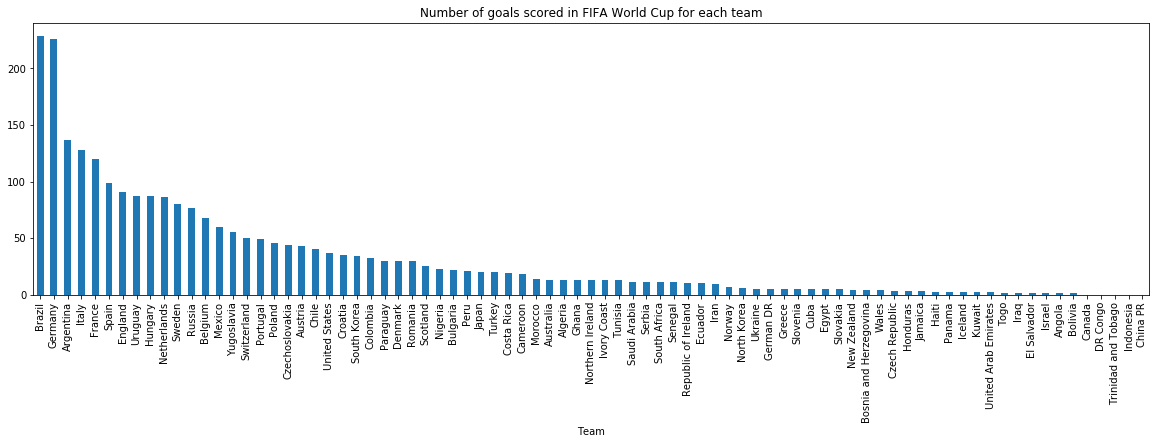

In [24]:
nb_goals = [(WC_data[WC_data['home_team']==team]).home_score.sum()+(WC_data[WC_data['away_team']==team]).away_score.sum() for team in list(WC_match_participants.unique())] 
    
WC_goals = {'Team': list(WC_match_participants.unique()), 'Goals': nb_goals}
WC_goals = pd.DataFrame.from_dict(WC_goals, orient='index').T.set_index(['Team'])
WC_goals=WC_goals.sort_values(by=['Goals'], ascending=False)
pd.DataFrame(WC_goals).plot.bar(y=0,legend=False, figsize=(20,5),
                                               title='Number of goals scored in FIFA World Cup for each team')
plt.show()

We note that a high number of participation does, however, not necessarily imply a high number of goals, Mexico is a good example.

/Users/leobouraux/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



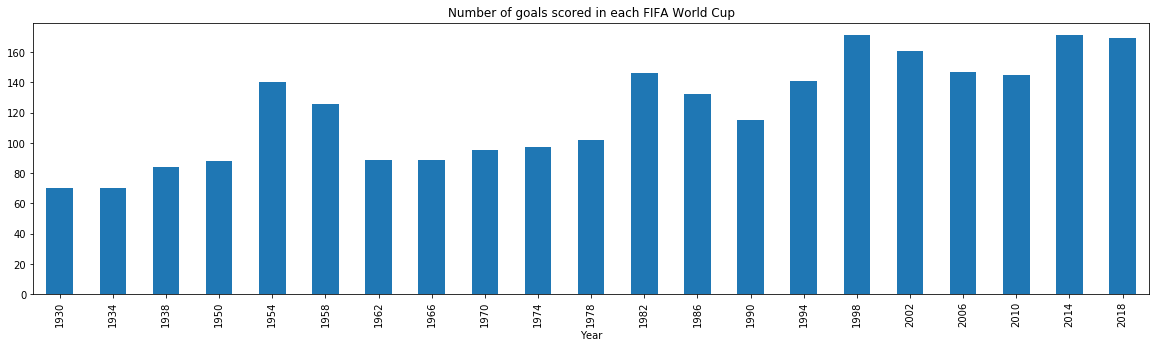

In [25]:
dates = sorted(list(set([d[:4] for d in list(WC_data['date'])])))
WC_data['date'] = WC_data['date'].apply(lambda x: x[:4])
total = []
for d in dates:
    total.append( (WC_data[WC_data.date==d]).home_score.sum()+ (WC_data[WC_data.date==d]).away_score.sum())
WC_goals = {'Year': dates, 'Goals': total}
WC_goals = pd.DataFrame.from_dict(WC_goals, orient='index').T.set_index(['Year'])
pd.DataFrame(WC_goals).plot.bar(y=0,legend=False, figsize=(20,5),
                                               title='Number of goals scored in each FIFA World Cup')
plt.show()

In [26]:
teams = [len(set(WC_data[WC_data.date==d].away_team).union(set(WC_data[WC_data.date==d].home_team))) for d in dates]
participant = {'Year': dates, 'Participants': teams}
participant = pd.DataFrame.from_dict(participant, orient='index').T.set_index(['Year'])
display(participant.T)

Year         1930 1934 1938 1950 1954 1958 1962 1966 1970 1974 1978 1982 1986  \
Participants   13   16   15   13   16   16   16   16   16   16   16   24   24   

Year         1990 1994 1998 2002 2006 2010 2014 2018  
Participants   24   24   32   32   32   32   32   32

More goals have been scored during the most recent world cup competitions, but this is probably due to a greater number of participants.

___
## Match location
### Distribution of match locations per country (top and bottom 50)


In [27]:
country_count = pd.DataFrame(data['country'].value_counts())
nb = country_count.loc["England"]  + country_count.loc["Scotland"] + country_count.loc["Wales"]
country_count.loc['United Kingdom'] = [nb.values.item()]

data3 = dict(type = 'choropleth', colorscale = 'Reds', locations = country_count.index,
            locationmode = 'country names', z = country_count['country'], text = country_count.index,
            colorbar = {'title':'Nb of hosted matches'})

layout3 = dict(title = 'Number of matches hosted per country',
               geo = dict(showframe = False, projection = {'type':'natural earth'}))

choromap3 = go.Figure([data3],layout3)
pyo.iplot(choromap3)

The United States have hosted the highest number of matches so far, even though they are not among the top ten teams that have played the most games. We anticipate the fact that most of them might be neutral game hostings. Let's visualize this:

In [28]:
us_matches = data[data['country']=='United States']

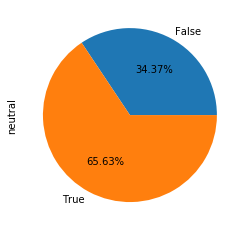

In [29]:
pd.DataFrame(us_matches['neutral']).groupby(us_matches['neutral']).count().plot.pie(y=0, autopct='%1.2f%%', startangle=0, legend=False)
plt.show()

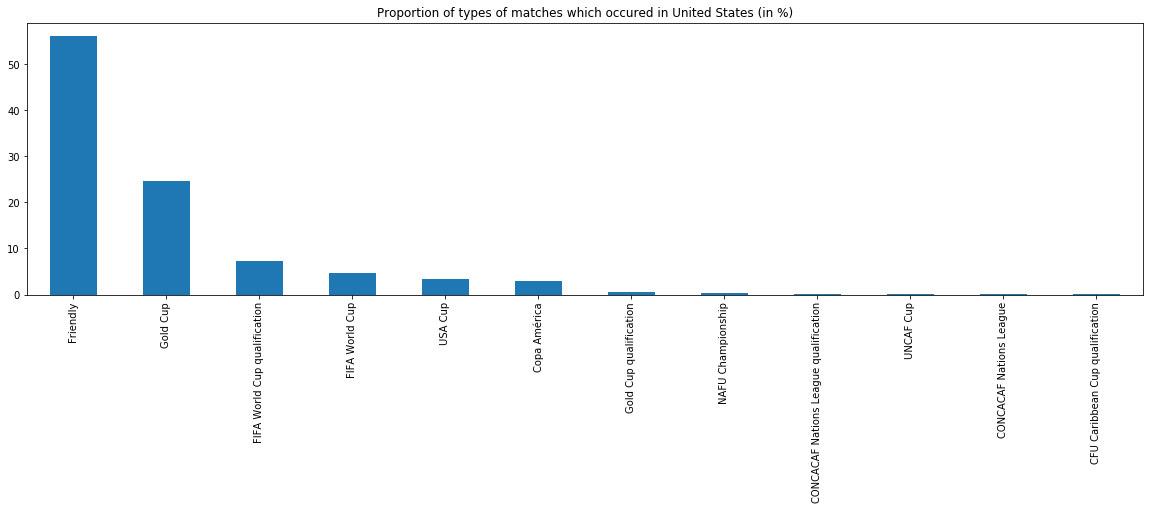

In [30]:
(us_matches['tournament'].value_counts()/us_matches['tournament'].count()*100).plot.bar(y=0, legend=False, figsize=(20, 5),
                                                                    title='Proportion of types of matches which occured in United States (in %)')
plt.show()

Indeed, we can see that the majority of matches played in the US are neutral matches. That being said, aside friendlies, a considerable amount of matches that have been played are from the Gold Cup competition (main North American championship).

### Distribution of matches played per city (top and bottom 50)


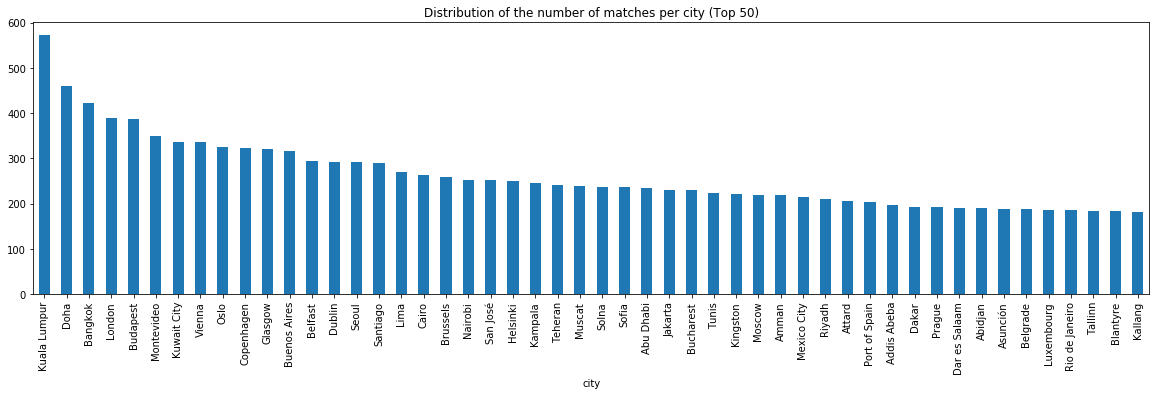

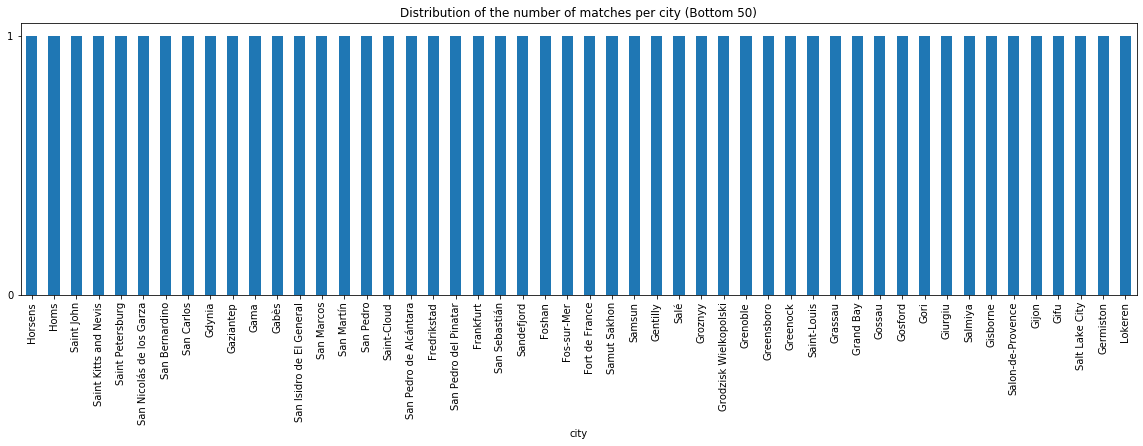

In [31]:
city_count=data['city'].groupby(data['city']).count().sort_values(0, ascending=False)
pd.DataFrame(city_count[:50]).plot.bar(y=0,legend=False, figsize=(20,5), title='Distribution of the number of matches per city (Top 50)')
pd.DataFrame(city_count[-50:]).plot.bar(y=0,legend=False, figsize=(20,5), title='Distribution of the number of matches per city (Bottom 50)')
plt.yticks([0,1])
plt.show()

## Neutral, home and away matches

### Repartition of matches on neutral vs non-neutral fields


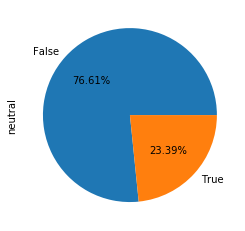

In [32]:
city_count=data['neutral'].groupby(data['neutral']).count()
pd.DataFrame(city_count[:10]).plot.pie(y=0,legend=False, autopct='%1.2f%%', startangle=0)
plt.show()

### Comparative statistics on final scores on neutral vs non-neutral fields


In [33]:
neutral_matches=data[data['neutral']==True]
non_neutral_matches=data[data['neutral']==False]
neutral_diff=np.abs(neutral_matches['home_score']-neutral_matches['away_score'])
non_neutral_diff=np.abs(non_neutral_matches['home_score']-non_neutral_matches['away_score'])
non_neutral_advantage=non_neutral_matches['home_score']-non_neutral_matches['away_score']

print('For Neutral Fields:')
print('Mean difference in score -  -  :', round(np.mean(neutral_diff), 3))
print('Median difference in score  -  :',round(np.median(neutral_diff), 3))
print('Std of the difference in score :',round(np.std(neutral_diff), 3))

print('\nFor Non-Neutral Fields:')
print('Mean difference in score -  -  -  -  -  -  - :',round(np.mean(non_neutral_diff), 3))
print('Median difference in score  -  -  -  -  -  - :',round(np.median(non_neutral_diff), 3))
print('Std of the difference in score -  -  -  -  - :',round(np.std(non_neutral_diff), 3))
print('Mean advantage in score for home teams  -  - :',round(np.mean(non_neutral_advantage), 3))
print('Median advantage in score for home teams   - :',round(np.median(non_neutral_advantage), 3))
print('Std of the advantage in score for home teams :',round(np.std(non_neutral_advantage), 3))

For Neutral Fields:
Mean difference in score -  -  : 1.685
Median difference in score  -  : 1.0
Std of the difference in score : 1.842

For Non-Neutral Fields:
Mean difference in score -  -  -  -  -  -  - : 1.658
Median difference in score  -  -  -  -  -  - : 1.0
Std of the difference in score -  -  -  -  - : 1.661
Mean advantage in score for home teams  -  - : 0.651
Median advantage in score for home teams   - : 1.0
Std of the advantage in score for home teams : 2.255


### Repartition of home vs away team wins on non-neutral fields


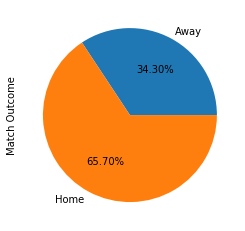

In [34]:
non_neutral_victories=non_neutral_advantage[non_neutral_advantage!=0]
non_neutral_victories[non_neutral_advantage>0]='Home'
non_neutral_victories[non_neutral_advantage<0]='Away'
non_neutral_victories=non_neutral_victories.groupby(non_neutral_victories).count()
pd.DataFrame(non_neutral_victories).rename(columns={0:'Match Outcome'}).plot.pie(y=0, legend=False, autopct='%1.2f%%', startangle=0)
plt.show()

### Compararative statistics on goals scored by home vs away teams on non-neutral fields

In [35]:
print('For Home Teams:')
print('Mean score       :', round(np.mean(non_neutral_matches['home_score']), 3))
print('Median score     :', round(np.median(non_neutral_matches['home_score']), 3))
print('Std of the score :', round(np.std(non_neutral_matches['home_score']), 3))

print('\nFor Away Teams:')
print('Mean score       :', round(np.mean(non_neutral_matches['away_score']), 3))
print('Median score     :', round(np.median(non_neutral_matches['away_score']), 3))
print('Std of the score :', round(np.std(non_neutral_matches['away_score']), 3))

For Home Teams:
Mean score       : 1.764
Median score     : 1.0
Std of the score : 1.703

For Away Teams:
Mean score       : 1.113
Median score     : 1.0
Std of the score : 1.283


We can deduce that :

- Most matches take place on a non-neutral field.
- Matches on non-neutral fields are mostly won by home teams.
- The average number of goals scored by home teams is considerably higher than for away teams.
- Matches on a neutral field have more varied results and higher mean score difference.

### Repartition of goals scored between home and away teams depending on the type of match

In [36]:
home_score_list = list(data.groupby(data['tournament']).home_score.sum())
away_score_list = list(data.groupby(data['tournament']).away_score.sum())

In [37]:
t1={'x':tournament_list,'y':home_score_list,'name':'Home Score','type':'bar', 'marker':dict(color = 'orange')};
t2={'x':tournament_list,'y':away_score_list,'name':'Away Score','type':'bar', 'marker':dict(color = 'rgb(58, 119, 155)')};
data1=[t1,t2]
layout = {'xaxis': {'title': 'Tournaments'},
          'barmode': 'relative',
          'title': 'Repartition of goals between home and away team depending on the type of match'};
fig = go.Figure(data = data1, layout = layout)
pyo.iplot(fig)

# Dataset Limitations

The only limitation that came to light through this analysis is the following:

In [39]:
#Getting the list of teams which don't exist anymore (teams which don't play since 2010)

past_years = list(map(str, np.arange(2010,2020)))
all_teams = pd.concat([data['home_team'],data['away_team']]).unique()
not_play_past_y = all_teams
for y in past_years:
    teams = data[data['date'].str.startswith(y)]
    teams_y=pd.concat([teams['home_team'],teams['away_team']]).unique()
    not_play_y = list(set(all_teams)-set(teams_y))
    not_play_past_y = np.intersect1d(not_play_past_y, not_play_y)
print(not_play_past_y)

['Czechoslovakia' 'German DR' 'Saarland' 'Vietnam Republic' 'Yemen DPR'
 'Yugoslavia']


Some teams have disolved or lost legitimacy over time and will need to be taken care of.